# Example for analyzing ome-zarr data from SPIMprep outputs

In [36]:
import zarr
import dask.array as da
import numpy as np
from dask.diagnostics import ProgressBar

In [37]:
#spimprep_dir='/home/ROBARTS/alik/graham/cfmm-bids/Prado/LightsheetMicroscopy/bids_spimprep_20240213'
spimprep_dir='/home/ROBARTS/alik/graham/scratch/3_processing/SPIMprep/results'

zarr_file=f'{spimprep_dir}/sub-mouse1/micr/sub-mouse1_acq-4x_desc-stitchedflatcorr_sample-brain_stain-abeta_spim.ome.zarr.zip'


## Reading data

In [38]:
#read in the zar (zipped) using zarr.open() to see what is there
z = zarr.open(zarr_file)
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='0 (1616, 7169, 6049) …

In [39]:
#the folders are called "groups" in zarr, and the arrays are "datasets"
 # can build a path with slashes 

dataset = z['/0']
dataset


<zarr.core.Array '/0' (1616, 7169, 6049) >u2>

In [40]:
# there is also metadata (OME-Zarr) for the multiscale image
z['/'].attrs.asdict()

{'multiscales': [{'axes': [{'name': 'z',
     'type': 'space',
     'unit': 'micrometer'},
    {'name': 'y', 'type': 'space', 'unit': 'micrometer'},
    {'name': 'x', 'type': 'space', 'unit': 'micrometer'}],
   'datasets': [{'coordinateTransformations': [{'scale': [0.004,
        0.0027083330000000003,
        0.0027083330000000003],
       'type': 'scale'}],
     'path': '0'},
    {'coordinateTransformations': [{'scale': [0.004,
        0.0054166660000000005,
        0.0054166660000000005],
       'type': 'scale'}],
     'path': '1'},
    {'coordinateTransformations': [{'scale': [0.004,
        0.010833332000000001,
        0.010833332000000001],
       'type': 'scale'}],
     'path': '2'},
    {'coordinateTransformations': [{'scale': [0.004,
        0.021666664000000002,
        0.021666664000000002],
       'type': 'scale'}],
     'path': '3'},
    {'coordinateTransformations': [{'scale': [0.004,
        0.043333328000000004,
        0.043333328000000004],
       'type': 'scale'}],


In [41]:
#TODO: remove toplevel fused folder (for OME napari compatibility)

In [42]:
#read in the full-resolution image as a dask array
darr = da.from_zarr(zarr_file,component='/0')
darr

dask.array<from-zarr, shape=(1616, 7169, 6049), dtype=>u2, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [43]:
#reading is instantaneous since we don't actually read the data

#dask gives you a virtual array, and you can use dask.array functions or slicing to manipulate the data virtually

darr_slice = darr[1000,:,:]
darr_slice

dask.array<getitem, shape=(7169, 6049), dtype=>u2, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [17]:
#if we want to get the actual data, we use da.compute()
arr_slice = darr_slice.compute()
arr_slice

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 141, 144, ..., 151,  94,   0],
       [  0, 149, 150, ..., 149,  90,   0],
       ...,
       [  0, 162, 158, ..., 163, 163,   0],
       [  0, 157, 156, ..., 152, 159,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype='>u2')

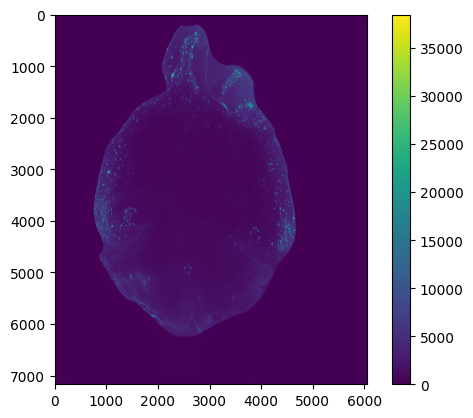

In [18]:
#now we can plot it for example:
import matplotlib.pyplot as plt

plt.imshow(arr_slice)
plt.colorbar()

KeyboardInterrupt: 

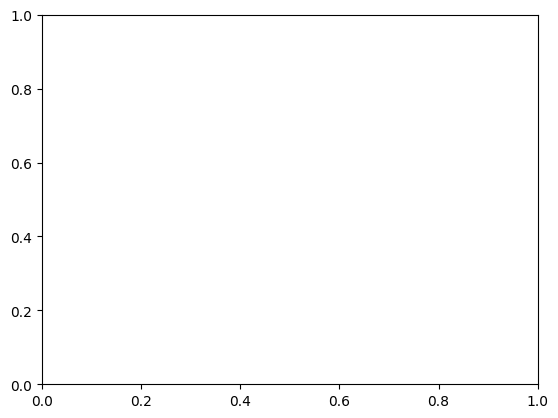

In [20]:
#can also grab the data from the zarr object, and use numpy to convert to numpy array
ds4=np.array(z['/4'])
plt.hist(ds4.flat)

## Computing over each block, first try on synthetic data

In [52]:
#we can use dask to also perform computations in parallel on each block
# this is done easily by defining a function and using da.map_blocks()

threshold=5000
def threshold_vol(x):
    mask=x>threshold
    nvoxels=sum(mask.flat)
    return np.array(nvoxels).reshape((1,1,1))



In [53]:
arr = 10000*np.random.random((100,100,100))
threshold_vol(arr)

array([[[500567]]])

In [54]:
#arr_nvox = darr_nvox.compute()

In [55]:
darr = da.from_array(arr,(10,10,10))
darr

dask.array<array, shape=(100, 100, 100), dtype=float64, chunksize=(10, 10, 10), chunktype=numpy.ndarray>

In [56]:
darr_nvox  = darr.map_blocks(threshold_vol,chunks=(1,1,1))
darr_nvox

dask.array<threshold_vol, shape=(10, 10, 10), dtype=int64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>

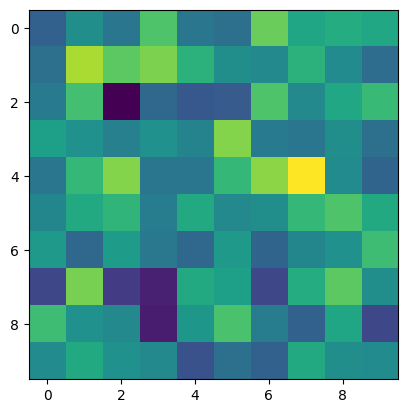

In [57]:
plt.imshow(darr_nvox.compute()[0,:,:])

## Now try on real data

In [58]:
#now try on our actual data 
darr = da.from_zarr(zarr_file,component='/0')

#we grab a smaller set of data for illustrative purposes (4 slices)
# and also rechunk to 1x100x100 chunks
darr_nvox = darr[28:32,:,:].rechunk(chunks=(1,100,100)).map_blocks(threshold_vol,chunks=(1,1,1))

In [186]:
darr_nvox

dask.array<threshold_vol, shape=(4, 72, 61), dtype=int64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>

In [187]:
#the result is small enough to be held in memory, so lets compute
# add a progress bar too
from dask.diagnostics import ProgressBar

with ProgressBar():
    arr_nvox=darr_nvox.compute()

[########################################] | 100% Completed | 48.57 s


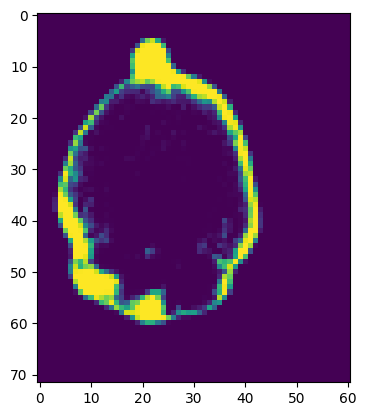

In [188]:
plt.imshow(arr_nvox[2,:,:])

## Let's try something more sophisticated



In [59]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'prediction + input overlay')

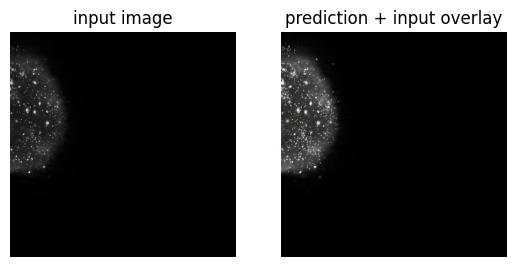

In [71]:
#try running the model on a slice
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

img = darr[30,3000:5000,3000:5000].squeeze().compute()

labels, _ = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

In [72]:
# note: _ contains coords, points, prob)


In [84]:
chunkdim=256
max_intensity=30000

#now let's try with dask
def stardist_2d(x):
    print(x.shape)
    #predict_instances needs to be 
    labels,_=model.predict_instances(np.clip(x.reshape((x.shape[1],x.shape[2]))/max_intensity,0,1))
    return labels.reshape(x.shape)
    


In [85]:
darr_labelled = darr[800:801,:,:].rechunk((1,chunkdim,chunkdim)).map_blocks(stardist_2d,dtype='uint16')

#darr_labelled = darr[800:801,:,:].map_blocks(stardist_2d,dtype='uint16')

darr_labelled

(0, 0, 0)


dask.array<stardist_2d, shape=(1, 7169, 6049), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

In [86]:
with ProgressBar():
    arr_labelled = darr_labelled.compute()

[########################################] | 100% Completed | 36.22 s


In [77]:
max_intensity

30000

Text(0.5, 1.0, 'prediction + input overlay')

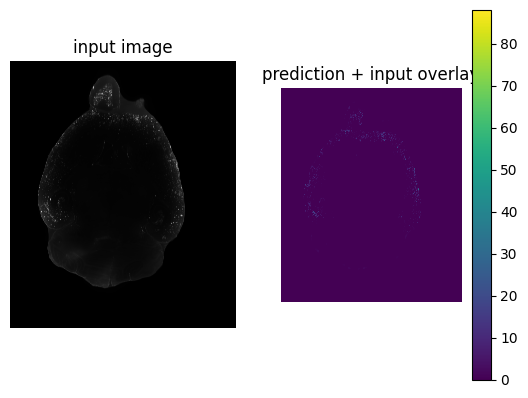

In [88]:

plt.subplot(1,2,1)
plt.imshow(darr[800,:,:], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(arr_labelled[0,:,:])
plt.colorbar()
plt.axis("off")
plt.title("prediction + input overlay")

In [90]:
#save as nifti to overlay in itksnap
import nibabel as nib
nib_img = nib.Nifti1Image(darr[800:801,:,:],affine=np.eye(4))
nib_img.to_filename('test_img.nii')

In [91]:
nib_lbl = nib.Nifti1Image(arr_labelled,affine=np.eye(4))
nib_lbl.to_filename('test_lbl.nii')
